# Deep Neural Networks: Libraries comparison

## I) Network:
L-layers neural network for binary and multi-class classifications

### Activation functions
- **ReLU**: $A = RELU(Z) = max(0, Z)$
- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$
- **Softmax** $\sigma(Z) = \sigma(W A + b) = \frac{e^{Z}}{\sum^K_{k=1}e^{Z_k}}$

### Cost Function with L2 Regularization
- **Cross-Entropy Loss (Binary)**: $ \frac{1}{m}\sum^m_{i=1} y^{(i)}*log(\hat y^{[L](i)}) + (1-y^{(i)})*log(1- \hat y^{[L](i)}) + \frac{\lambda}{2*m}\sum_l \sum_k \sum_j (W^{[l]}_{k,j})^2 $
- **Cross-Entropy Loss (Multi-class)**: $ \frac{1}{m}\sum^m_{i=1} y^{(i)}*log(\hat y^{[L](i)}) + \frac{\lambda}{2*m}\sum_l \sum_k \sum_j (W^{[l]}_{k,j})^2 $

### Optimizer 
- **Mini-Batch Gradient Descent**
- $ W^{\{k\}[l]} = W^{\{k\}[l]} - \alpha * dW^{\{k\}[l]}$
- $ b^{\{k\}[l]} = b^{\{k\}[l]} - \alpha * db^{\{k\}[l]}$


## II) Datasets
- **Cat vs Non Cat pictures (binary classification)**
    - a training set of 209 images labelled as cat (1) or non-cat (0)
    - a test set of 50 labelled as cat and non-cat
    - each image is of shape (64, 64, 3) where 3 is for the 3 channels (RGB).


- **MNIST Dataset (multi-class classification)**
    - a training set of 14.000 images labelled as cat (1) or non-cat (0)
    - a test set of 1.400 labelled as cat and non-cat
    - each image is of shape (28, 28, 1)

In [1]:
from utili_np import *
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

Binary Dataset: Cat vs Non Cat Classification


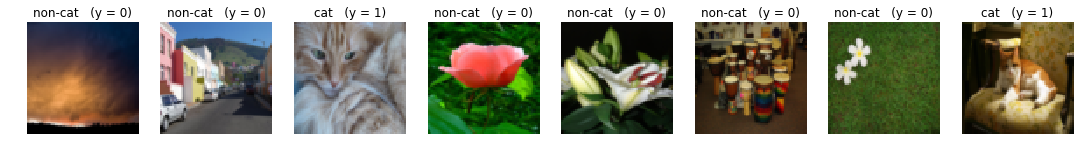

Multi-Class Dataset: MNIST


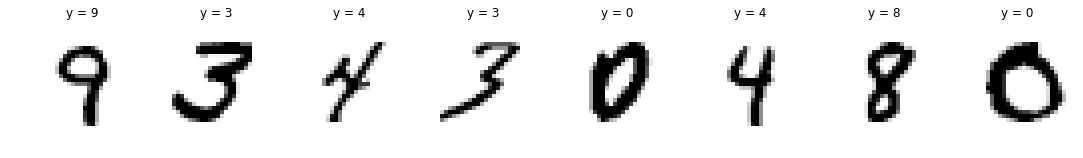

In [2]:
dataset_show(num_images = 8)

## 1) Numpy
### 1-A) Numpy Implementation

In [4]:
def initialize_params(nx, ny, hidden_layers):
    "Initialization of parameters W and b"

    #Creation of list with layer dimensions
    layer_dims = []
    layer_dims.append(nx)
    for i in range(len(hidden_layers)):
        layer_dims.append(hidden_layers[i])
    layer_dims.append(ny)
    assert(len(layer_dims) == len(hidden_layers)+2)

    params = {}
    L = len(layer_dims)
    for l in range(1,L):

        #Xavier Initialization
        params["W"+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1/ layer_dims[l-1])
        params["b"+str(l)] = np.zeros((layer_dims[l], 1))

    assert(params['W'+str(l)].shape == (layer_dims[l], layer_dims[l-1]))
    assert(params['b'+str(l)].shape == (layer_dims[l], 1))

    return params
    
#%% Forward Prop
def layer_FP(A_prev, W, b, activation):
    
    Z = np.dot(W, A_prev) + b
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "softmax":
        A = softmax(Z)
    elif activation == "relu":
        A = relu(Z)
    
    cache = (A_prev, W, b, Z)
    return A, cache
        
def forward_prop(X, params):
    
    A = X
    L = len(params) // 2 # Number of parameters lead to the number of layers
    ny = params["W"+str(L)].shape[0]
    caches = []
    for l in range(1,L+1):
        A_prev = A
        if l != L:
            A, cache = layer_FP(A_prev, params["W"+str(l)], params["b"+str(l)],
                                           activation = "relu")
            caches.append(cache)
        else:
            if ny == 1:
                A, cache = layer_FP(A_prev, params["W"+str(l)], params["b"+str(l)],
                                               activation = "sigmoid")
            else:
                A, cache = layer_FP(A_prev, params["W"+str(l)], params["b"+str(l)],
                                               activation = "softmax")
            caches.append(cache)
            
    return A, caches

#%% Cost function
def compute_cost(A, Y, parameters, lambd):

    m = Y.shape[1]
    ny = Y.shape[0]
    L = len(parameters)//2
    reg_cost = 0
    
    #Cost function
    if ny == 1: #Cross entropy loss for binary classification
        cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
        
    else:#Cross entropy loss for multi-class classification
        cost = -1/m * np.sum(Y*np.log(A))
        
    #Regularization term
    for l in range(1, L+1):
        reg_cost += np.sum(parameters["W" + str(l)]**2)
        
    reg_cost = lambd/(2*m)*reg_cost
    cost = cost + reg_cost
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

#%% Backward Prop
def layer_BP(dA, cache, activation, lambd, m):
    """To compute a single layer BackProp"""
    
    A_prev, W, b, Z = cache
    
    if activation == "relu":
        dZ = relu_derivative(dA, Z)
    elif activation == "sigmoid":
        dZ = sigmoid_derivative(dA, Z)
    elif activation == "softmax":
        dZ = dA
        
    m = A_prev.shape[1]
    dW = 1/m*np.dot(dZ, A_prev.T) + lambd/m * W
    db = 1/m*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    return dA_prev, dW, db
    
def backward_prop(A, Y, caches, lambd):

    grads = {}
    L = len(caches)
    m = A.shape[1]
    ny = A.shape[0]
    Y = Y.reshape(A.shape)
    
    if ny == 1:
        grads["dA"+str(L)] = - Y/A + (1-Y)/(1-A) #dJ/dA for binary cross entropy
    else:
        grads["dA"+str(L)] = A - Y #This is already dZ

    for l in reversed(range(L)):
        cache = caches[l]
        if l != L-1:
            d_A_prev, dW, db = layer_BP(grads["dA"+str(l+1)], cache, "relu", lambd, m)
        
        else:
            if ny == 1:
                d_A_prev, dW, db = layer_BP(grads["dA"+str(l+1)], cache, "sigmoid", lambd, m)
            else:
                d_A_prev, dW, db = layer_BP(grads["dA"+str(l+1)], cache, "softmax", lambd, m)
            
        grads["dA"+str(l)], grads["dW"+str(l+1)], grads["db"+str(l+1)] = d_A_prev, dW, db
        #In case of 1 layer I compute cost as f(A1, Y) then I compute dA1 before
        # and then I use bp to compute dZ1 and dW1, db1 and dA0(not useful in this case)
    return grads


#To use to compare the correctness of the Backprop derivatives. Otherwise it can be ignored.
def gradient_check(X, Y, params, grads, lambd, eps = 1e-7):
    
    theta = dict_to_vector(params) #to unroll the matrices of parameters in a vector
    d_theta = dict_to_vector(grads)#to unroll the matrices of gradients in a vector
    num_params = theta.shape[0] #length of the vector, same for dtheta
    J_plus = np.zeros((num_params,1))
    J_minus = np.zeros((num_params,1))
    d_theta_approx = np.zeros((num_params,1))
    
    for i in range(num_params): #at every loop I modify just one element
        theta_plus = np.copy(theta)  #Otherwise theta_plus will always remain equal to theta
        theta_minus = np.copy(theta) # Arrays are like lists: mutable
        theta_plus[i][0] += eps
        theta_minus[i][0] -= eps
        params_plus = vector_to_dict(theta_plus, params)
        params_minus = vector_to_dict(theta_minus, params)
        A_plus, _ = forward_prop(X, params_plus)
        A_minus, _ = forward_prop(X, params_minus)
        J_plus[i] = compute_cost(A_plus, Y, params_plus, lambd)
        J_minus[i] = compute_cost(A_minus, Y, params_minus, lambd)
        
        #Every element of d_theta_approx is the result of slight increase on a single value
        d_theta_approx[i] = (J_plus[i] - J_minus[i])/(2*eps)
        
    difference = np.linalg.norm(d_theta - d_theta_approx)/(
            np.linalg.norm(d_theta) + np.linalg.norm(d_theta_approx))
    
    if difference < 1e-7:
        print("Implementation of Backprop Correct!")
    else:
        print("Alt: Possible problem with Backprop")
        
    return difference, d_theta_approx 
    
#%% Gradient Descent
def update_params(params, grads, alpha):
    
    L = len(params)//2
    for l in range(1, L+1):
        params['W'+str(l)] = params['W'+str(l)] - alpha*grads['dW'+str(l)]
        params['b'+str(l)] = params['b'+str(l)] - alpha*grads['db'+str(l)]
    
    return params

   
#%%  Accuracy estimation
def predict(X, Y, params):
    "The function predicts the accuracy of a neural network with trained params"
    m = X.shape[1]
    P = np.zeros((1,m))
    Y_new= np.zeros((1,m)) #For multiclass prediction
    A, caches = forward_prop(X, params)
    assert(A.shape[1] == m)
    
    #Binary Case
    if A.shape[0] == 1:
        for i in range(m):
            if A[0,i] > 0.5:
                P[0,i] = 1
        acc = np.sum(P == Y) / m
    #Multi class case  
    else:
        for i in range(m):
            P[0,i] = np.argmax(A[:,i]) #I take the most confident of my units. The value is given by its position in the vector.
            Y_new[0,i] = np.argmax(Y[:,i])
        acc = np.sum(P == Y_new) / m
    
    return P, acc

#%% Activation Functions
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    return A

def softmax(Z):
    """
    Input: Z = (nx, m)  Output: A = (nx, m)
    """
    T = np.exp(Z - np.max(Z)) #np max is just a  trick for numerical stability, it cancels out
    sumt = np.sum(T, axis = 0, keepdims = True)
    A = T/sumt
    assert(A.shape == Z.shape)
    return A

def sigmoid_derivative(dA, Z):
    a = 1/(1+np.exp(-Z))
    dZ = dA * a * (1-a)
    assert (dZ.shape == Z.shape)
    return dZ

def relu_derivative(dA, Z):
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
                                #copy = True is default
    dZ[Z <= 0] = 0 # When z <= 0, you should set dz to 0. 
    assert (dZ.shape == Z.shape)
    return dZ



### 1-B Gradient Checking

In [5]:
new_case = np.load("NN_example.npz")
NN_ex =new_case['arr_0']
params = NN_ex[()]["params"]
grads_ex = NN_ex[()]["grads"]
X = NN_ex[()]["X"]
Y = NN_ex[()]["Y"].reshape(1,3)
lambd = 1
A, caches = forward_prop(X, params)
grads = backward_prop(A, Y, caches, lambd)

difference, d_theta_approx = gradient_check(X, Y, params, grads, lambd, eps = 1e-7)
#print(grads["dA2"])
#print(d_theta_approx["dA2"])
#print(grads_ex["dA2"])
d_theta_approx[0]
print(difference)


Implementation of Backprop Correct!
8.066416832680387e-09


## 0) Controller

In [18]:
# A) Dataset Selection: 1 for "Binary Cat dataset"     2 for "MNIST Dataset"
dataset = 2
n_train = 10000 #number of example in the training set (only for MNIST Dataset- up to 12.600)
n_val = 1000 #number of example in the validation set (only for MNIST Dataset- up to 1400)
n_test = 1000 #number of example in the training set (only for MNIST Dataset- up to 1400)

#B) NN architecture
L1 = 30
L2 = 20
hidden_layers = [L1, L2]

# C) Hyperparameters selection
alpha = 0.1  
n_epochs = 200
mb_size = 128
lambd = 0.2 #regularization parameter


In [19]:
# Image loading
if dataset == 1:
    X_train, Y_train, X_val, Y_val, classes = load_cats_dataset()

if dataset == 2:
    X_train, Y_train, X_val, Y_val, X_test, Y_test, classes = load_MNIST_dataset(n_train, n_val, n_test)
    
m = X_train.shape[1]
nx = X_train.shape[0]
ny = Y_train.shape[0]

### 1-C) Numpy Main Script

Cost after iteration 0: 2.386913
Cost after iteration 20: 0.425714
Cost after iteration 40: 0.373750
Cost after iteration 60: 0.352416
Cost after iteration 80: 0.342430
Cost after iteration 100: 0.335946
Cost after iteration 120: 0.331735
Cost after iteration 140: 0.329637
Cost after iteration 160: 0.328359
Cost after iteration 180: 0.324218
time: 78 seconds 


 3 layers neural network


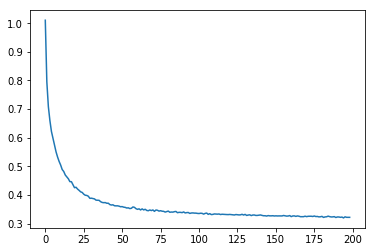

Training Accuracy: 0.9939
Cross-Validation Accuracy: 0.95


Mislabelled examples


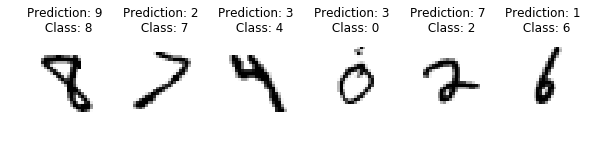

In [20]:
np.random.seed(0)
#Parameters Initialization
params = initialize_params(nx, ny, hidden_layers)

#%% 2) Neural Network Training

costs = [] #Save cost at every iteration to print
num_minibatches = m//mb_size
start = time.time() #for time estimation

for epoch in range(n_epochs):
    
    epoch_cost = 0
    minibatches = random_mini_batches(X_train, Y_train, num_minibatches)
    
    for mb in minibatches:
        (mb_X, mb_Y) = mb
    
        #Forward Propagation
        A, caches = forward_prop(mb_X, params)

        #Cost Function
        mb_cost = compute_cost(A, mb_Y, params, lambd)

        #Backward propagation
        grads = backward_prop(A, mb_Y, caches, lambd)

        #Update parameters
        params = update_params(params, grads, alpha)
    
        epoch_cost += mb_cost/num_minibatches #Every minibatches contributes to the epoch cost
        
    #Print Cost every 100 iterations
    if epoch % (n_epochs//10) == 0: 
        print("Cost after iteration %i: %f" %(epoch, epoch_cost))
    costs.append(epoch_cost)
    
end = time.time()
print("time: " + str(int(end-start))+" seconds \n")
print("\n %i layers neural network" %(len(hidden_layers)+1))
plt.figure(2)
plt.plot(np.squeeze(costs[1:]))
plt.show()

#%% 3) Evaluate Performancies

#Calculate Accuracies
P_train, acc_train = predict(X_train, Y_train, params)
print("Training Accuracy: "+str(acc_train))
P_val, acc_val = predict(X_val, Y_val, params)
print("Cross-Validation Accuracy: "+str(acc_val))
print("\n")
print("Mislabelled examples")

#Printing Mislabeled Examples
printing_mislabeled_images(X_val, Y_val, P_val, classes, num_images = 6)

## 2) TensorFlow
### 2-A) TensorFLow Implementation

In [21]:
import tensorflow as tf
def tf_create_placeholders(nx, ny):
    with tf.name_scope('input'):
        X = tf.placeholder(shape = [nx, None], dtype = "float", name = "X")
        Y = tf.placeholder(shape = [ny, None], dtype = "float", name = "Y")
        #prob = tf.placeholder_with_default(1.0, shape=())
    return X,Y

def tf_initialize_parameters(nx, hidden_layers, ny):
#for key, nh in layers_dims.items()
    layer_dims = []
    layer_dims.append(nx)
    for i in range(len(hidden_layers)):
        layer_dims.append(hidden_layers[i])
    layer_dims.append(ny)
    assert(len(layer_dims) == len(hidden_layers)+2)

    params = {}
    L = len(layer_dims)
    for l in range(1,L):
        params["W"+str(l)] = tf.get_variable("W"+str(l),[layer_dims[l], layer_dims[l-1]],
                                                         initializer = tf.contrib.layers.xavier_initializer())
        params["b"+str(l)] = tf.get_variable("b"+str(l), [layer_dims[l], 1], initializer = tf.zeros_initializer())

    return params


def tf_forward_prop(X, params):
    A = X
    L = len(params) // 2
    for l in range(1,L+1):
        A_prev = A
        if l != L:
            Z = tf.add(tf.matmul(params['W'+str(l)], A_prev), params['b'+str(l)])
            A = tf.nn.relu(Z)
        else:#Last layer output = Z as needed from the cost function
            Z = tf.add(tf.matmul(params['W'+str(l)], A_prev), params['b'+str(l)]) 
    return Z

def tf_compute_cost(Z,Y, params, lambd, m):
    L = len(params) // 2
    Z = tf.transpose(Z)
    Y = tf.transpose(Y) #To compute cost I need batch size a first dimension
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits = Z, labels = Y, name = 'Cost'))
    
    m = tf.cast(tf.shape(Y)[0],tf.float32)# it can output only int32 or int64 but tf needs float32
    
    for l in range(1, L):
        cost = tf.add(cost, lambd/m * (tf.nn.l2_loss(params["W" + str(l)])))

    return cost

### 2-B) TensorFlow Main Script

Cost after iteration 0: 1.897774
Cost after iteration 20: 0.343177
Cost after iteration 40: 0.239720
Cost after iteration 60: 0.191852
Cost after iteration 80: 0.177841
Cost after iteration 100: 0.164538
Cost after iteration 120: 0.143577
Cost after iteration 140: 0.290874
Cost after iteration 160: 0.161146
Cost after iteration 180: 0.147150
time: 135 seconds 


 3 layers neural network


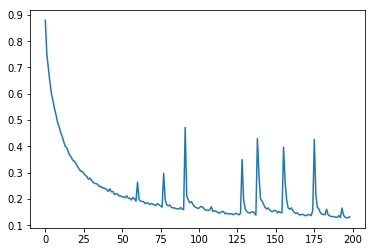

Training Accuracy 0.9997
Cross-Validation Accuracy 0.953


In [22]:
if ny == 1:
    Y_train = convert_to_one_hot(Y_train, ny)
    Y_val = convert_to_one_hot(Y_val, ny)
    Y_test = convert_to_one_hot(Y_test, ny)

start = time.time()

# Cancel previous graphs
tf.reset_default_graph()

#Create placeholders
X, Y = tf_create_placeholders(nx, ny)

#Initalize parameters
params = tf_initialize_parameters(nx, hidden_layers, ny)

#Forward prop
Z3 = tf_forward_prop(X, params)

#Cost Function
cost = tf_compute_cost(Z3, Y, params, lambd, m)

#Optimizer choice
optimizer = tf.train.GradientDescentOptimizer(learning_rate = alpha).minimize(cost)
costs = []

init = tf.global_variables_initializer()
with tf.Session().as_default() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    # (tensorboard --logdir="./graphs")
    
    for epoch in range(n_epochs):   
        epoch_cost = 0
        minibatches = random_mini_batches(X_train, Y_train, num_minibatches)
        
        for mb in minibatches:
            (mb_X, mb_Y) = mb
            _, mb_cost = sess.run([optimizer, cost], feed_dict = {X:mb_X, Y:mb_Y})
            
            epoch_cost += mb_cost/num_minibatches
    
        if epoch % (n_epochs//10) == 0: 
            print("Cost after iteration %i: %f" %(epoch, epoch_cost))
        costs.append(epoch_cost)
        
end = time.time()
print("time: " + str(int(end-start))+" seconds \n")
print("\n %i layers neural network" %(len(hidden_layers)+1))
plt.figure(2)
plt.plot(np.squeeze(costs[1:]))
plt.show()

with sess.as_default():   
    correct_prediction =  tf.equal(tf.argmax(Z3), tf.argmax(Y))   
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Training Accuracy", accuracy.eval({X:X_train, Y:Y_train}))
    print("Cross-Validation Accuracy", accuracy.eval({X:X_val, Y:Y_val}))

    trained_params = sess.run(params) #it returns numpy array
